<a href="https://colab.research.google.com/github/Lusiji254/Pneumothorax-Segmentation-using-DeepLab/blob/main/Final_Prediction_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
'Colab Notebooks'  'Colab Notebooks (1)'   Pneumothorax
 Colab-Notebooks   'My Drive'


In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt 
from tqdm import tqdm
import tensorflow as tf
import keras.backend as K
from keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope

In [ ]:
from tensorflow.keras import backend as K
H = 256
W = 256
def final_pred(image_path,mask_path):
    size = 256
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (size, size))
    image = image / 255.0
    image = image.astype(np.float32)
    image = np.expand_dims(image, axis=0)


    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [size, size])
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.expand_dims(mask,axis=0)
    

      

    def iou(y_true, y_pred):
        smooth = 1
        def f(y_true, y_pred):
            intersection = (y_true * y_pred).sum()
            union = y_true.sum() + y_pred.sum() - intersection
            x = (intersection + 1e-15) / (union + 1e-15)
            x = x.astype(np.float32)
            return x
        return tf.numpy_function(f, [y_true, y_pred], tf.float32)

    smooth = 1
    def dice_coef(y_true, y_pred):
        y_true = tf.keras.layers.Flatten()(y_true)
        y_pred = tf.keras.layers.Flatten()(y_pred)
        intersection = tf.reduce_sum(y_true * y_pred)
        return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

    def dice_loss(y_true, y_pred):
        return 1.0 - dice_coef(y_true, y_pred)

    def f1(y_true, y_pred): #taken from old keras source code
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        recall = true_positives / (possible_positives + K.epsilon())
        f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
        return f1_val




    with CustomObjectScope({'f1':f1}):
        classification_model = tf.keras.models.load_model("/content/gdrive/MyDrive/Pneumothorax/pneumo-classify/chexnet_model.h5" )
    with CustomObjectScope({ 'iou': iou,'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        segmentation_model = tf.keras.models.load_model("/content/gdrive/MyDrive/Pneumothorax/pneumo-files/pneumo-model_aug.h5")


    
    pred = classification_model.predict(image)[0]
    pred = np.argmax(pred)
    # if the probabiliy score is greater than 0.5 then give class label=1 else 0
    if pred >0.5:
      whether_pneumothorax = 1
    else:
      whether_pneumothorax = 0

    # if pneumothorax is predicted from classification model, then predict segmentation
    if whether_pneumothorax:
        print("\n\n" + "*"*20 + " THIS IMAGE CONTAINS PNEUMOTHORAX " + "*"*20 )
        image = np.squeeze(image, axis=0)
        image = cv2.resize(image, (512, 512))
        image = np.expand_dims(image, axis=0)
        # if the image contains pneumothorax, predict the mask segmentation
        pred_ms =  segmentation_model.predict(image)
        pred_mask = (pred_ms[0]>0.5).astype(np.uint8)
        print(pred_mask.shape)

        plt.figure(figsize=(28,10))
        plt.subplot(131)
        print("\n\n" +" THIS IMAGE CONTAINS PNEUMOTHORAX " )
        plt.title("Original Image")
        plt.imshow(np.squeeze(image[0]),cmap='gray')

        plt.subplot(132)
        plt.title("Original Image with Predicted Mask")
        plt.imshow(np.squeeze(image[0]),cmap='gray',alpha=0.6)
        plt.imshow(np.squeeze(pred_mask),cmap='Reds',alpha=0.4)

        plt.subplot(133)
        plt.title("Original Image with Original Mask")
        plt.imshow(np.squeeze(image[0]),cmap='gray',alpha=0.6)
        plt.imshow(np.squeeze(mask[0]),cmap='Greens',alpha=0.4)

        
        return plt.show()
    else:
        print("\n\n" + "*"*20 + " THIS IMAGE DOES NOT CONTAIN PNEUMOTHORAX " + "*"*20 )
        plt.figure(figsize=(36,10))
        plt.subplot(131)
        print("\n\n"  + " THIS IMAGE DOES NOT CONTAIN PNEUMOTHORAX " )
        plt.title("Original Image")
        plt.imshow(np.squeeze(image[0]),cmap='gray')

        plt.subplot(132)
        plt.title("Original Mask")
        plt.imshow(np.squeeze(mask[0]),cmap='Greens')
        return plt.show()

        fig = plt.figure()
        plt.imshow(np.squeeze(image[0]),cmap='gray',alpha=0.6)
        plt.imshow(np.squeeze(mask[0]),cmap='Greens',alpha=0.4)
        plt.axis("off")
        st.pyplot(fig)




1/1 [==============================] - 10s 10s/step


******************** THIS IMAGE CONTAINS PNEUMOTHORAX ********************
1/1 [==============================] - 3s 3s/step
(512, 512, 1)


 THIS IMAGE CONTAINS PNEUMOTHORAX 


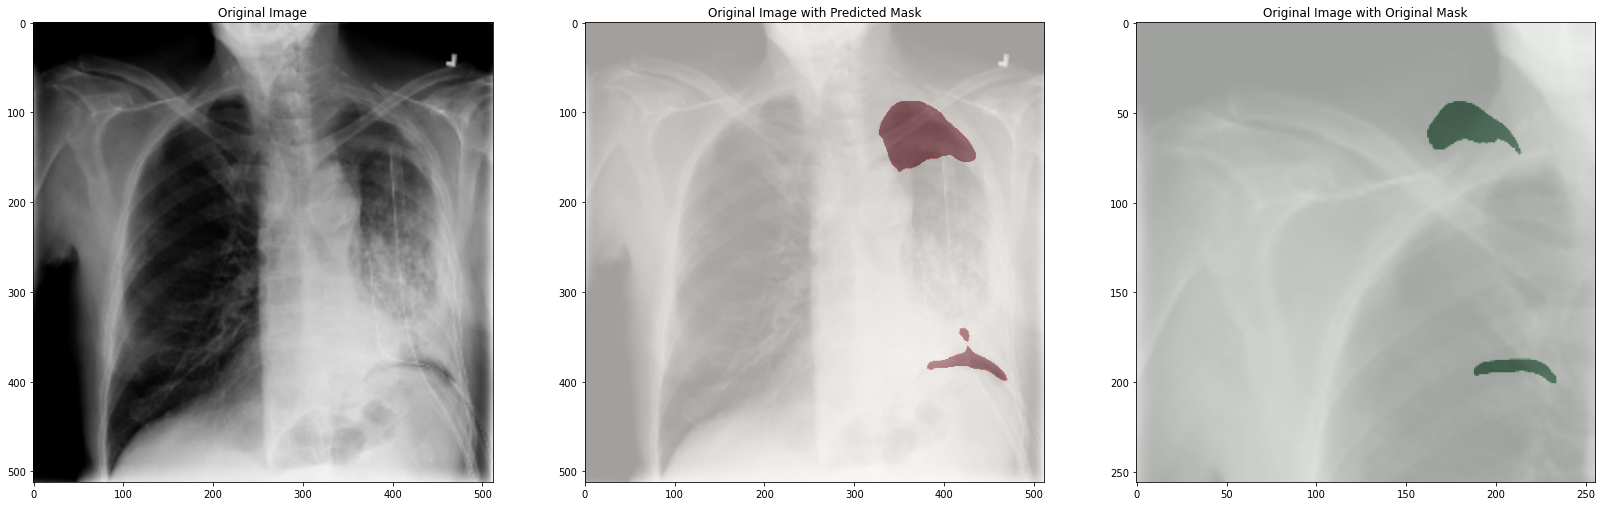

In [ ]:
plot_show = final_pred(image_path = "/content/gdrive/MyDrive/Pneumothorax/test_images/0_test_1_.png", mask_path ="/content/gdrive/MyDrive/Pneumothorax/test_masks/0_test_1_.png")